# **Conditional DCGAN using TensorFlow 2.0**

This notebook aims to learn how to use Conditional Deep Convolutional Generative Adversarial Network (Conditionnal DCGAN) using TensorFlow 2.0.

Thus, we will use the CIFAR-10 dataset.

## 1) Imports and preliminaries

As we will use TensorBoard to visualize the training of the convolutional DCGAN, we have to import it.

In [1]:
%load_ext tensorboard.notebook

We remove the previous logs.

In [2]:
!rm -rf ./logs/ 

Imports : 
* <font color='blue'>TensorFlow 2.0</font> ( pip install tensorflow==2.0.0-alpha0 OR pip install tensorflow-gpu==2.0.0-alpha0 )
* <font color='blue'>Datetime</font> ( pip install DateTime )
* <font color='blue'>Glob</font> ( sudo pip install glob3 )
* <font color='blue'>ImageIO</font> ( pip install imageio )
* <font color='blue'>MatPlotLib</font> ( pip install python-matplotlib )
* <font color='blue'>NumPy</font> ( pip install numpy )
* <font color='blue'>Os</font> ( already in Python's standard library )
* <font color='blue'>PIL</font> ( pip install Pillow )
* <font color='blue'>Time</font> ( already in Python's standard library )
* <font color='blue'>IPython</font> ( pip install ipython )

In [3]:
import tensorflow as tf
import datetime
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## 2) Loading the training and test datasets

To keep it simple, we will use the CIFAR-10 dataset.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

Reshaping and normalizing the data so the shape is compatible with our DCGAN.

In [5]:
train_images.shape

(50000, 32, 32, 3)

In [6]:
if len(train_images.shape) == 3:
    train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1).astype('float32')
else:
    train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

Here is the difference between Conditional DCGANs and classic DCGANs : we add a one hot label for each category of image so that the DCGAN can categorize what he will learn and generate, and the discriminator now have to guess if this image of this label (we specify to it) is real of fake.

Here, we define a one hot tensor.

In [7]:
num_categories = len(set(train_labels.reshape(train_labels.shape[0])))

In [8]:
train_labels.shape

(50000, 1)

In [9]:
train_labels = tf.one_hot(train_labels, num_categories)
train_labels = tf.reshape(train_labels, (tf.shape(train_labels)[0], tf.shape(train_labels)[2]))

In [10]:
train_labels

<tf.Tensor: id=16, shape=(50000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

Defining the batch size.

To learn more about the batch size and what it is about : https://www.youtube.com/watch?v=U4WB9p6ODjM.

In [11]:
BATCH_SIZE = 256

## 3) Building the Genetator and the Discriminator

The role of the generator is to extract the sens of the dataset, so that it can generate some images with the same sens.

To understand the generator's structure, you might want to imagine it like a **reversed Convolutional Neural Network (CNN)** :
* At the beginning of the generator, you should have what you usually find at the end of a CNN : a small image with a lot of channels (small, small, big).
* At the end of the generator, you should have what you usually find at the beginning of a CNN : an basic image (big, big, 1~3).

Our model for the generator is the following :
* input_shape of (100,) : it is the random noise every GAN needs to generate images, concatenated with its label (what category of image it is).
* Dense 7x7x256, just like the flattened end of a CNN (small, small, big) without bias because the next layer already adds a bias.
* Batch Normalization : normalizes the output of the previous layer and helps the training. Learn more about it here : https://www.youtube.com/watch?v=dXB-KQYkzNU.
* LeakyReLU activation. Leaky ReLU instead of normal ReLU to avoid gradient problems. Learn more about it here : https://www.quora.com/What-are-the-advantages-of-using-Leaky-Rectified-Linear-Units-Leaky-ReLU-over-normal-ReLU-in-deep-learning.

* Reshape : inverse of the flatten we usually find in CNNs.

* Conv2DTranspose : inverse of the Conv2D we usually find in CNNs. No bias for the same reasons as above. (5, 5) is the size of the window, and strides is the step between each window. Then Batch Norm + Leaky ReLU.

* Conv2DTranspose + Batch Norm + Leaky ReLU

* Conv2DTranspose + TanH activation this time, because it allows the model to learn more quickly to saturate and cover the color space of the training distribution.

In [12]:
def generator_model(input_layer, condition_layer):
    
    merged_in = layers.Concatenate()([input_layer, condition_layer])
    
    hid = layers.Dense(8*8*256, use_bias=False)(merged_in)
    hid = layers.BatchNormalization()(hid)
    hid = layers.LeakyReLU()(hid)

    hid = layers.Reshape((8, 8, 256))(hid)

    hid = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization()(hid)
    hid = layers.LeakyReLU()(hid)

    hid = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.BatchNormalization()(hid)
    hid = layers.LeakyReLU()(hid)

    out = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(hid)

    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    model.summary()
    
    return model

The role of the discriminator is to learn the difference between a real image and a generated image.

The discriminator is basically a CNN without pooling between every convolution, so that the discriminator learns how to reduce the size of each layer by itself. This time, we also specify the label to it ("Is this image of 6 real or fake ?") by concatenating after all the convolutions.

We use dropout layers to build consistency and resistance, avoiding overfitting.

In [13]:
def discriminator_model(input_layer, condition_layer):

    
    hid = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_layer)
                                    
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.4)(hid)

    hid = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(hid)
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.4)(hid)

    hid = layers.Flatten()(hid)
    
    merged = layers.Concatenate()([hid, condition_layer])
    hid = layers.Dense(128, activation="sigmoid")(merged)
    out = layers.Dense(1)(hid)
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    model.summary()
    
    return model

In [14]:
img_input = layers.Input(shape=train_images.shape[1:])

In [15]:
disc_cond_in = layers.Input(shape=(num_categories,)) # Amount of classes
gen_cond_in = layers.Input(shape=(num_categories,))

Generating the discriminator.

In [16]:
discriminator = discriminator_model(img_input, disc_cond_in)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16, 16, 64)   0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

Generating the generator.

In [17]:
noise_input = layers.Input(shape=(100,))
generator = generator_model(noise_input, gen_cond_in)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16384)        1802240     concatenate_1[0][0]        

Generation of the noise to give to the DCGAN, and a random label for now.

In [18]:
noise = tf.random.normal([1,100])
condition = tf.one_hot([7],num_categories)

Let's see first how he processes random noise before training :

In [19]:
generated = generator([noise,condition],training=False)

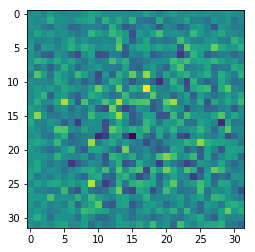

In [20]:
plt.imshow(generated[0, :, :, 0])#, cmap='rgb')

Let's the the discriminator's prediction (real or fake ?) :

In [21]:
decision = discriminator([generated,condition], training=False)
print (decision)


tf.Tensor([[0.02922055]], shape=(1, 1), dtype=float32)


## 5) Loss, optimizer & checkpoints determination

As the loss for the generator and the discriminator are a bit special, we define them manually.

In [22]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    #La real_loss va quantifier notre loss pour distinguer les vraies images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    #La fake_loss va quantifier notre loss pour distinguer les fausses images (générées)
    
    #Vrai = 1, faux =0 (array de 1 et zéros, de taille 1 dans notre cas)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def generator_loss(fake_output):
    #On veut que notre fausse image soit considérée vraie (1)
    return loss_function(tf.ones_like(fake_output), fake_output)


We use the classical Adam optimizer, which is basically a better gradient descent.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We use checkpoints so that 
* we can make a GIF afterwards
* not everything is lost in case of malfunction

In [26]:
checkpoint_dir = './training_checkpoints_conditionnal'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6) Training

In [27]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16 #Pour l'affichage

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = tf.one_hot([0,1,2,3,4,5,6,7,8,9,1,2,3,8,7,9], 10)

@tf.function will translate this function code (written in Eager mode) into its equivalent in Graph mode. To make it simple, Eager mode is easier to code, but takes longer to compile and run, while Graph mode is harder to code, but way faster than Eager mode. So using @tf.function, we keep the good points of each size : we code in Eager mode, and then execute it in Graph mode. More about this : https://www.youtube.com/watch?v=sI7pP7NCZFg.

Here we define what a train step does : 
* The generator builds an image, based on a random noise.
* We give the discriminator two images : a real image, and a fake image made by the generator. It will give the probability of both of them being a real image.
* We measure the generator's loss using the discriminator's prediction, and the discriminator's loss using its predictions on both images.
* We build the gradients of both losses.
* We apply the gradients.

In [28]:


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,labels] , training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



Here, as we train the GAN, we measure time, save the model every 15 epochs and produce images in order to make a GIF at the end.

In [29]:
def train(train_images, train_labels, epochs):
    num_batches = int(train_images.shape[0]/BATCH_SIZE)
    for epoch in range(epochs):
        start = time.time()

        for batch_idx in range(num_batches):
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            labels = train_labels[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            train_step(images, labels)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 seed_labels)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                                seed_labels)


Creating a function to make the GAN generate an image.

In [30]:
def generate_and_save_images(model, epoch, test_input, conditions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model([test_input, conditions], training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)#, cmap='rgb')
        plt.axis('off')

    plt.savefig('imgs' + os.sep + 'cdcgan_cifar10' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


Configuring logs for TensorBoard

In [31]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir)


Timing the training

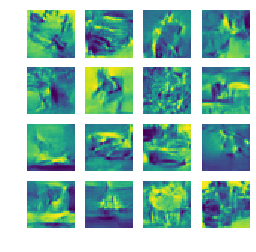

CPU times: user 29min 50s, sys: 4min 46s, total: 34min 37s
Wall time: 1h 33min 41s


In [32]:
%%time
train(train_images, train_labels, EPOCHS)

No need apparently

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 7) Visualizing

In [34]:
def display_image(epoch_no):
    return PIL.Image.open('imgs' + os.sep + 'cdcgan_cifar10' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch_no))

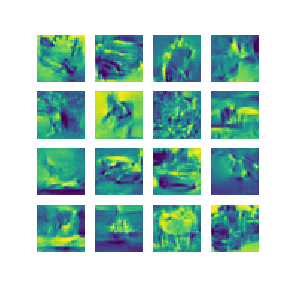

In [35]:
display_image(EPOCHS)

Creating the GIF

In [36]:
anim_file = 'cdcgan_cifar10.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('imgs' + os.sep + 'cdcgan_cifar10' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

Exporting the TensorBoard logs

In [38]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 11731), started 0:35:41 ago. (Use '!kill 11731' to kill it.)